In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from scipy.interpolate import griddata
from scipy.stats.stats import pearsonr

# Data adquisition and basic plotting

In [2]:
# data adquisition from the 5 simlations in the last timestep
_x2 = np.genfromtxt('./data/x2.csv', skip_header=1, delimiter=',')
_x3 = np.genfromtxt('./data/x3.csv', skip_header=1, delimiter=',')
_x  = np.genfromtxt('./data/x.csv', skip_header=1, delimiter=',')
_2x = np.genfromtxt('./data/2x.csv', skip_header=1, delimiter=',')
_3x = np.genfromtxt('./data/3x.csv', skip_header=1, delimiter=',')

# store the files inside lists
dataSets = [_x3, _x2, _x, _2x, _3x]
dataSetsString = ['x3', 'x2', 'x', '2x', '3x']

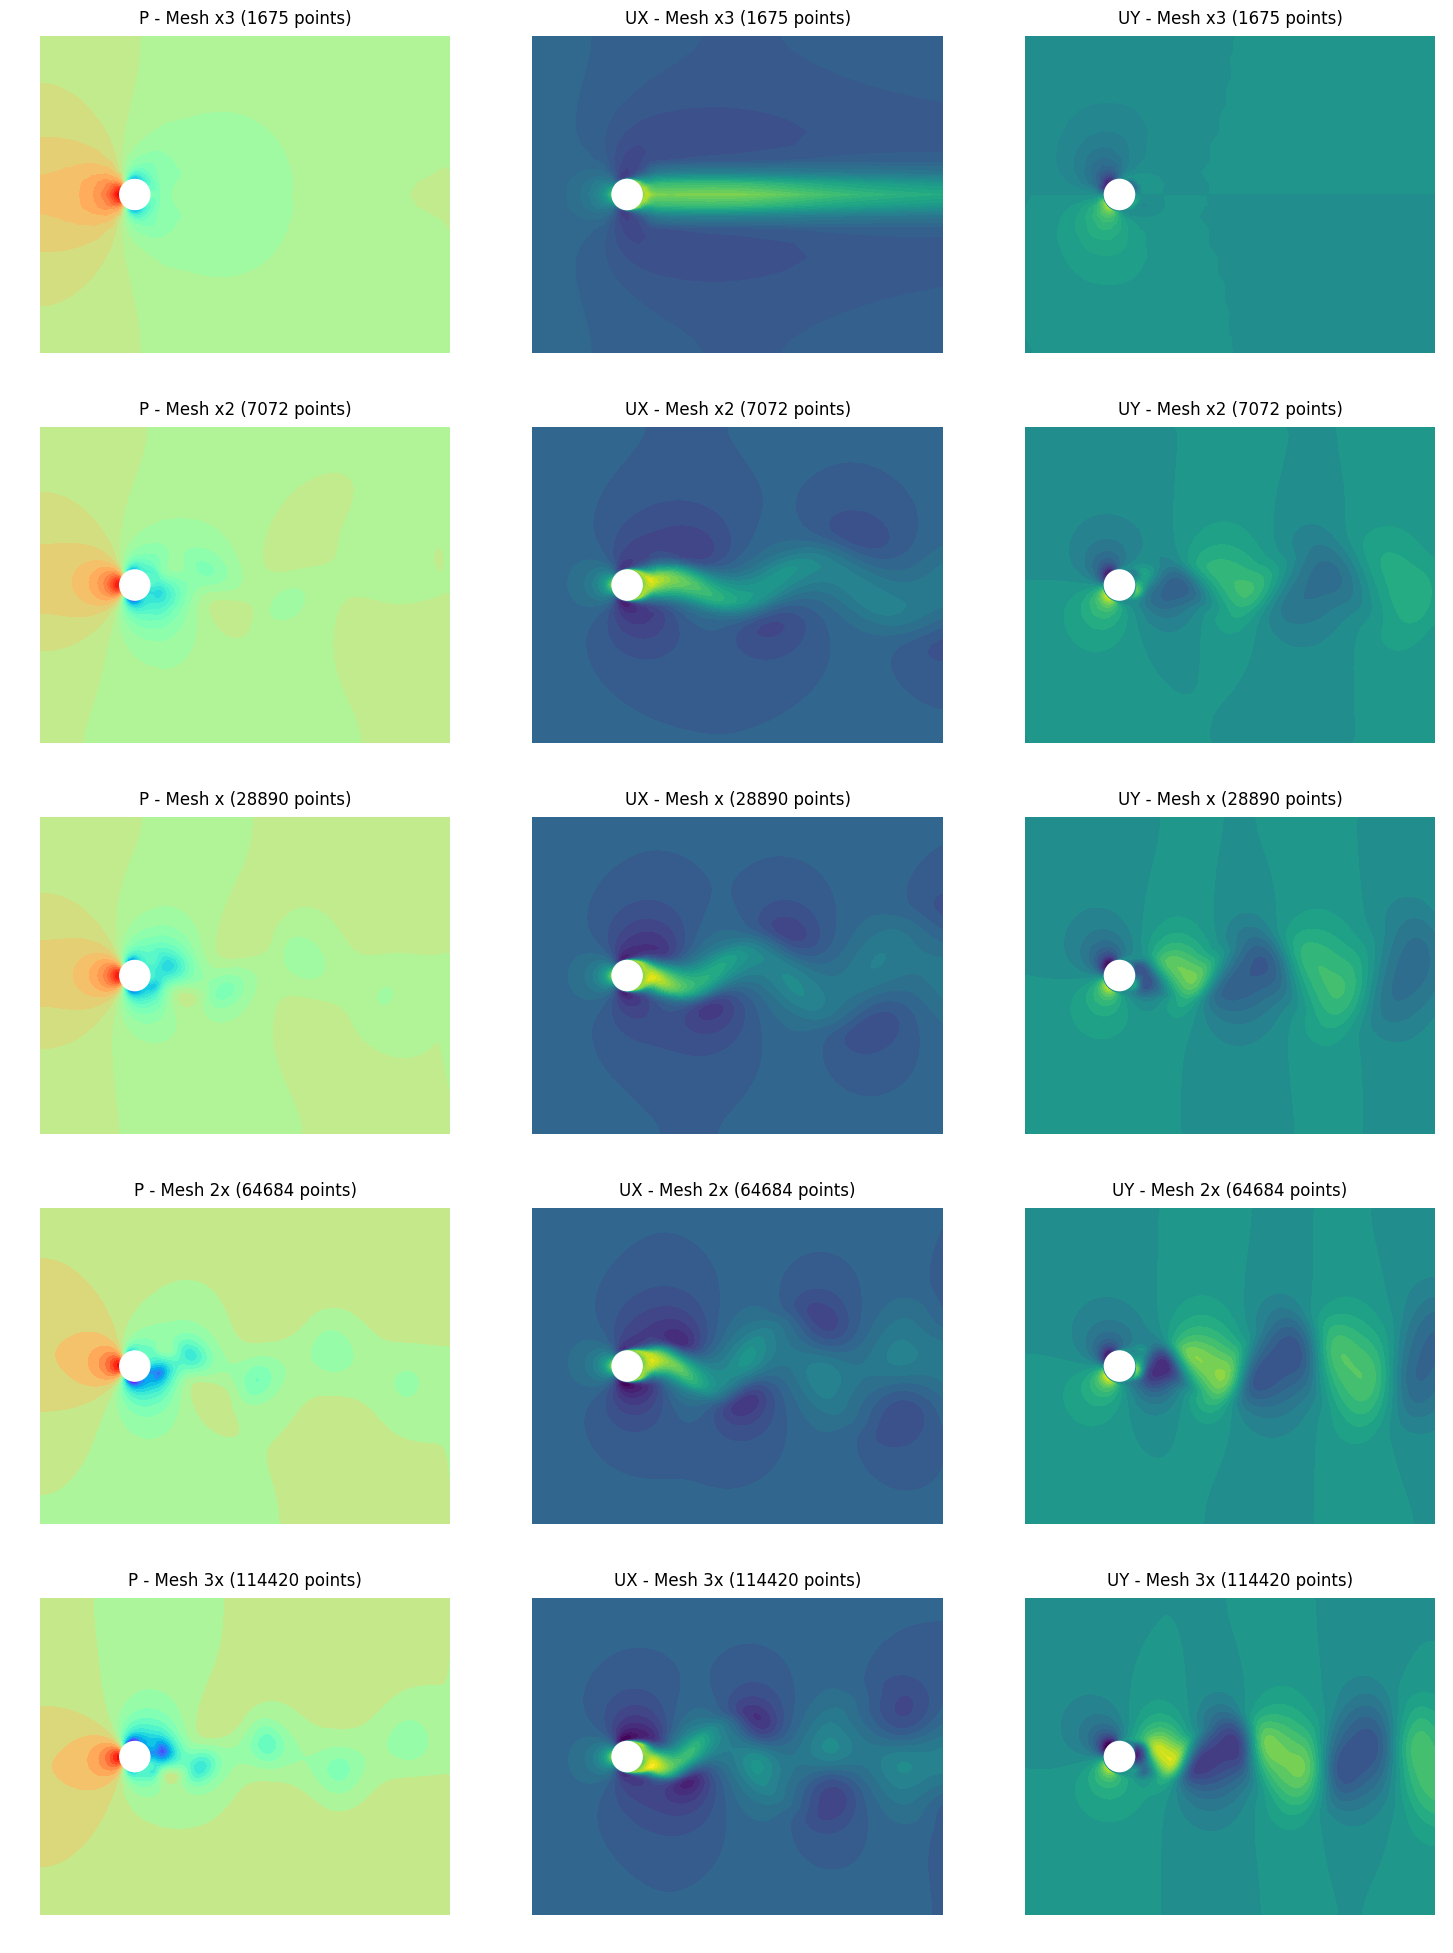

In [3]:
# basic potting
f, axes = plt.subplots(5, 3, sharex=True, figsize=(18,25), dpi=100)

# vertical levels for contours (more levels will take more time)
levels = 25

# minimum and maximum values for equal colorbars
# pressure plot
minVal0 = np.min([dataSets[i][:,0].min() for i in range(len(dataSets))])
maxVal0 = np.max([dataSets[i][:,0].max() for i in range(len(dataSets))])
# x-axis velocity
minVal1 = np.min([dataSets[i][:,1].min() for i in range(len(dataSets))])
maxVal1 = np.max([dataSets[i][:,1].max() for i in range(len(dataSets))])
# y-axis velocity
minVal2 = np.min([dataSets[i][:,2].min() for i in range(len(dataSets))])
maxVal2 = np.max([dataSets[i][:,2].max() for i in range(len(dataSets))])

# plot the same thing for all cases
for i in range(len(axes)):
    # pressure field
    axes[i][0].tricontourf(dataSets[i][:,4], dataSets[i][:,5], dataSets[i][:,0], levels, vmin = minVal0, vmax = maxVal0, cmap='rainbow')
    axes[i][0].set_title('P - Mesh %s (%i points)' %(dataSetsString[i], len(dataSets[i][:,0])))
    # x-axis velocity field
    axes[i][1].tricontourf(dataSets[i][:,4], dataSets[i][:,5], dataSets[i][:,1], levels, vmin = minVal1, vmax = maxVal1, cmap='viridis_r')
    axes[i][1].set_title('UX - Mesh %s (%i points)' %(dataSetsString[i], len(dataSets[i][:,1])))
    # y-axis velocity field    
    axes[i][2].tricontourf(dataSets[i][:,4], dataSets[i][:,5], dataSets[i][:,2], levels, vmin = minVal2, vmax = maxVal2, cmap='viridis_r')
    axes[i][2].set_title('UY - Mesh %s (%i points)' %(dataSetsString[i], len(dataSets[i][:,2])))

# setting equal axis, hiding the box and adding the circular patch
[axes[i][j].axis('equal') for j in range(3) for i in range(5)]
[axes[i][j].axis('off') for j in range(3) for i in range(5)]
[axes[i][j].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white")) for j in range(3) for i in range(5)]
    
# save image
plt.savefig('./cylinderMeshConv.png', bbox_inches='tight', dpi=300)

In [4]:
# create a list for the velocity vector (instead thtat by components)
V = []
[V.append(np.sqrt(dataSets[i][:,1]**2+dataSets[i][:,2]**2+dataSets[i][:,3]**2)) for i in range(len(dataSets))]

# find the maximum and minimum of those velocity vector
minValV = np.min([V[i].min() for i in range(len(V))])
maxValV = np.max([V[i].max() for i in range(len(V))])

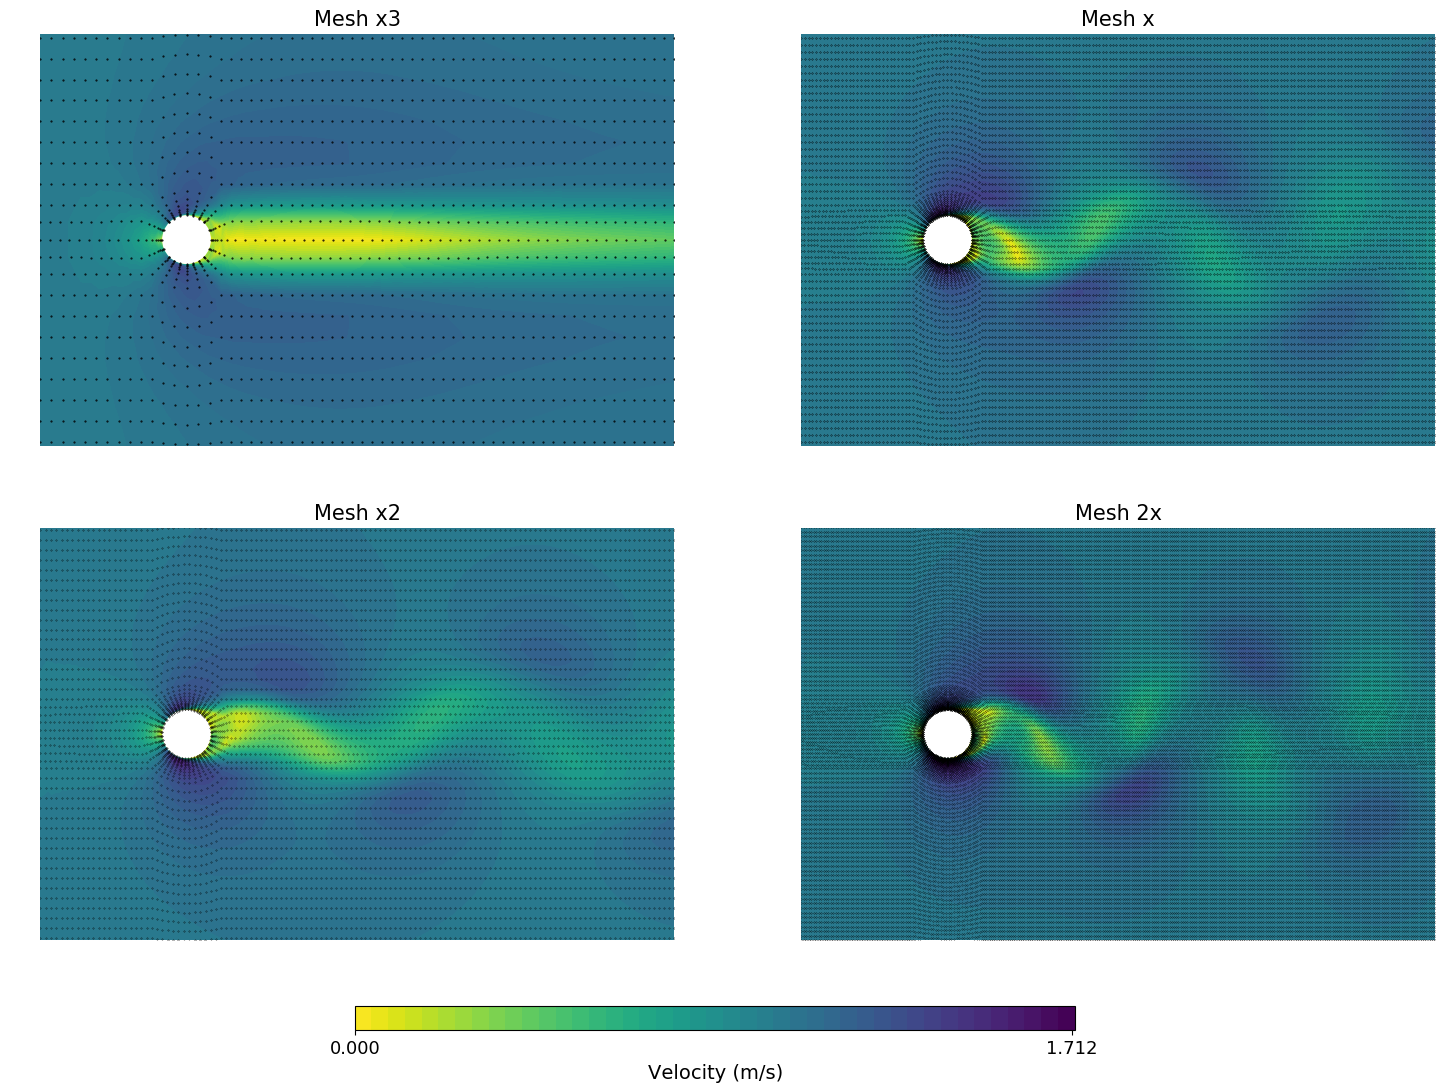

In [5]:
# let's plot the velocity vector
fig, ax = plt.subplots(2,2, sharex=True, figsize=(18,12), dpi=100)

# select a new value for contourf levels
levels = 50

# plot the different figures
for i in range(2):
    for j in range(2):
        # index of the list with respect to the figure grid
        k = i + 2*j
        var = ax[i][j].tricontourf(dataSets[k][:,4], dataSets[k][:,5], V[k], levels, vmin=minValV, vmax=maxValV, cmap='viridis_r')
        # add the position of the points
        ax[i][j].plot(dataSets[k][:,4], dataSets[k][:,5], 'k.', markersize=1/(k+1))
        # add title
        ax[i][j].set_title('Mesh %s' %dataSetsString[k], fontsize=15)

# setting equal axis, hiding the box and adding the circular patch
[ax[i][j].axis('equal') for j in range(2) for i in range(2)]
[ax[i][j].axis('off') for j in range(2) for i in range(2)]
[ax[i][j].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white")) for j in range(2) for i in range(2)]

# add colorbar legend
ccax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
ccbar = fig.colorbar(var,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([minValV,maxValV])
ccax.tick_params(axis = 'both', labelsize = 13)
ccbar.set_label('Velocity (m/s)', fontsize=14)

# save the figure
plt.savefig('./cylinderMeshConv_wGrid.png', bbox_inches='tight', dpi=300)

# Comparison of field data

The classical approach for mesh convergence takes a characteristic and representative value for each mesh, comparing them and expecting some convergence in the values. However, here there is not a clear value to use. Another option for mesh convergence is field operation, where fields from different meshes are substracted. Again, there is a problem in this case because the different meshes have different array sizes and it is not the same for all cases (given that the number of cells in each case varies). To face this problem, grid interpolation will be used, comparing different meshes one-by-one.

In [6]:
# objective grid to interpolate (the same for all meshes)
xi = np.linspace(-3,10,200)
yi = np.linspace(-5,5,200)
xi, yi = np.meshgrid(xi,yi)

# interpolation for each case - to have a full array with xi and yi as axis
case = np.zeros((len(dataSets), np.shape(yi)[0], np.shape(yi)[1], 3))
for i in range(len(dataSets)):
    case[i,:,:,0] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,0],(xi,yi),method='linear')
    case[i,:,:,1] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,1],(xi,yi),method='linear')
    case[i,:,:,2] = griddata((dataSets[i][:,4],dataSets[i][:,5]),dataSets[i][:,2],(xi,yi),method='linear')

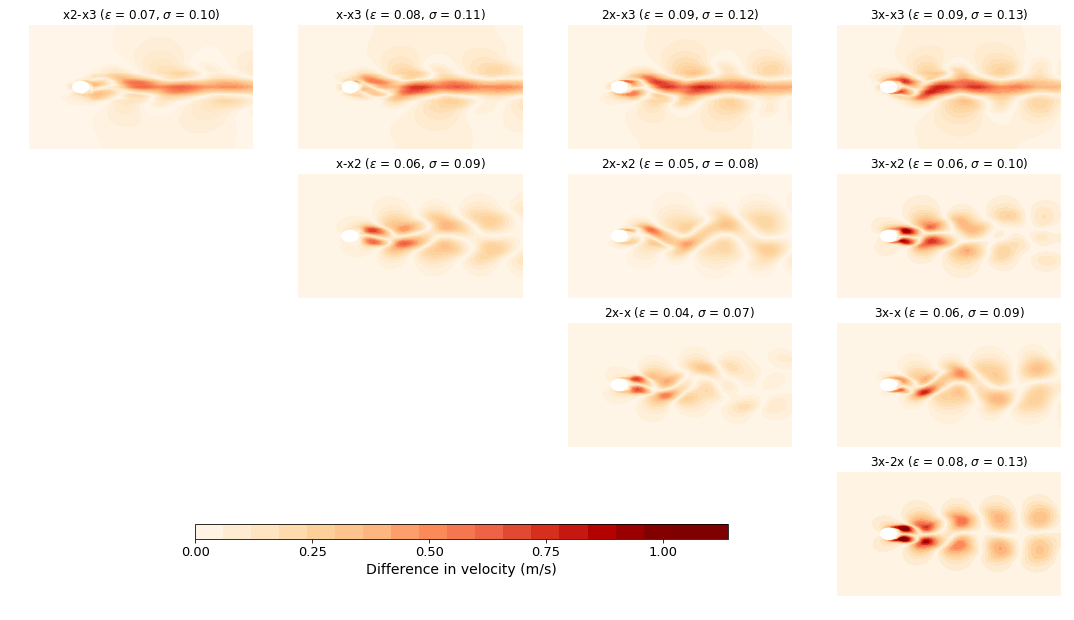

In [7]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(18.5,10.5), sharex='col', sharey='row')

# set number of levels in the contourf
levels = 20

# let's make a little space for the same-field comparison plots
ax5.axis('off')
ax9.axis('off')
ax10.axis('off')
ax13.axis('off')
ax14.axis('off')
ax15.axis('off')

# axes where the results will be shown
realSubplot = [ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax11, ax12, ax16]
# index for comparison of the values in the arrays
comparative = [[1,0],[2,0],[3,0],[4,0],[2,1],[3,1],[4,1],[3,2],[4,2],[4,3]]
# let's save the mean and standard deviation from the most accurate mesh (labeled right in the title)
mean = np.zeros(len(comparative))
std = np.zeros(len(comparative))

# plot the results
for i in range(len(realSubplot)):
    CS = realSubplot[i].contourf(xi, yi, abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]), levels, vmin = 0.0, vmax = 1.0, cmap='OrRd')
    realSubplot[i].add_patch(patches.Circle((0.0, 0.0), 0.5, facecolor="white"))
    realSubplot[i].axis('off')
    mean[i]  = np.mean(abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]))
    std[i] = np.std(abs(case[comparative[i][0],:,:,1]-case[comparative[i][1],:,:,1]))
    realSubplot[i].set_title(r'%s-%s ($\varepsilon$ = %.2f, $\sigma$ = %.2f)' %(dataSetsString[comparative[i][0]], dataSetsString[comparative[i][1]], mean[i], std[i]))
    
# add colorbar legend
ccax = fig.add_axes([0.25, 0.2, 0.4, 0.02])
ccbar = fig.colorbar(CS,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
ccax.tick_params(axis = 'both', labelsize = 13)
ccbar.set_label('Difference in velocity (m/s)', fontsize=14)
    
# save the figure
plt.savefig('./cylinderMeshConv_wGrid.png', bbox_inches='tight', dpi=300)

# Comparison with mesh properties

In [8]:
# Manually introduced values for the meshes (obtained with checkMesh)
nodes = np.array([3350, 14144, 28890, 64684, 114420])
faces = np.array([6415, 27694, 56925, 128084, 227130])
volumes = np.array([1580, 6874, 14160, 31814, 56640])

Are the different mesh parameters related among them?

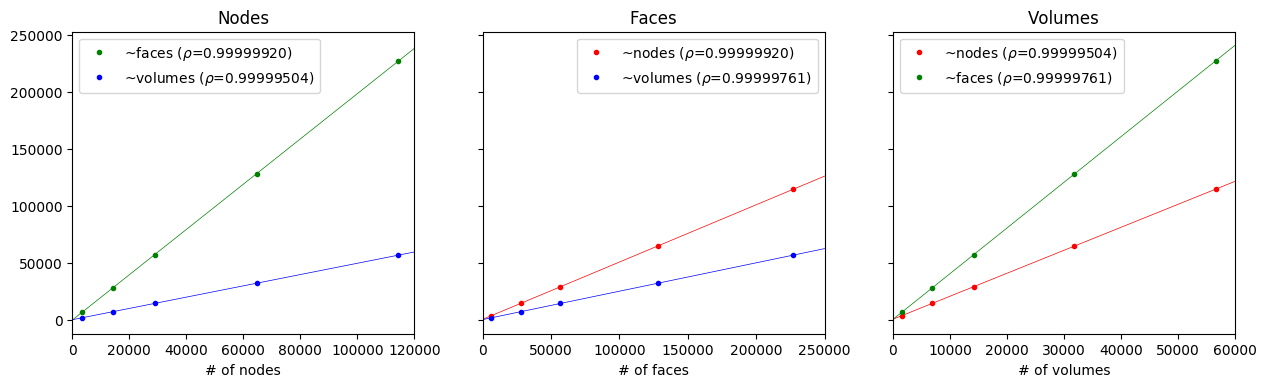

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4), dpi=100)

# Comparing nodes with faces and volumes 
ax1.plot(nodes,faces,'g.',label=r'~faces ($\rho$=%.8f)' %pearsonr(nodes,faces)[0])
ax1.plot(nodes,volumes,'b.',label=r'~volumes ($\rho$=%.8f)' %pearsonr(nodes,volumes)[0])
nf = np.poly1d(np.polyfit(nodes,faces,1))
nv = np.poly1d(np.polyfit(nodes,volumes,1))
ax1.plot([0,120000],nf([0,120000]),'g-',lw=0.5)
ax1.plot([0,120000],nv([0,120000]),'b-',lw=0.5)
ax1.set_xlabel('# of nodes')
ax1.set_title('Nodes')
ax1.set_xlim([0,120000])
ax1.legend()

# Comparing faces with nodes and volumes
ax2.plot(faces,nodes,'r.',label=r'~nodes ($\rho$=%.8f)' %pearsonr(faces, nodes)[0])
ax2.plot(faces,volumes,'b.',label=r'~volumes ($\rho$=%.8f)' %pearsonr(faces, volumes)[0])
fn = np.poly1d(np.polyfit(faces,nodes,1))
fv = np.poly1d(np.polyfit(faces,volumes,1))
ax2.plot([0,250000],fn([0,250000]),'r-',lw=0.5)
ax2.plot([0,250000],fv([0,250000]),'b-',lw=0.5)
ax2.set_xlabel('# of faces')
ax2.set_title('Faces')
ax2.set_xlim([0,250000])
ax2.legend()

# Comparing volumes with nodes and faces
ax3.plot(volumes,nodes,'r.',label=r'~nodes ($\rho$=%.8f)' %pearsonr(volumes, nodes)[0])
ax3.plot(volumes,faces,'g.',label=r'~faces ($\rho$=%.8f)' %pearsonr(volumes, faces)[0])
vn = np.poly1d(np.polyfit(volumes,nodes,1))
vf = np.poly1d(np.polyfit(volumes,faces,1))
ax3.plot([0,60000],vn([0,60000]),'r-',lw=0.5)
ax3.plot([0,60000],vf([0,60000]),'g-',lw=0.5)
ax3.set_xlabel('# of volumes')
ax3.set_title('Volumes')
ax3.set_xlim([0,60000])
ax3.legend()

At least for this case, all magnitudes are correlated. So, no matter which one we choose to analyze mesh convergence. Let's choose nodes

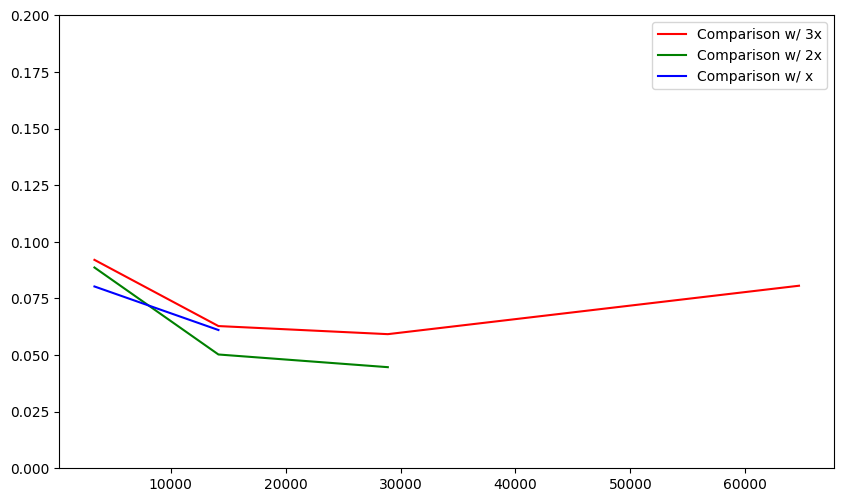

In [10]:
f, ax1 = plt.subplots(1, figsize=(10,6), dpi=100)
# plotting the mean error of each field substraction compared with respect different meshes
ax1.plot(nodes[:-1], mean[[3,6,8,9]], color = 'r', label='Comparison w/ 3x')
ax1.plot(nodes[:-2], mean[[2,5,7]], color = 'g', label='Comparison w/ 2x')
ax1.plot(nodes[:-3], mean[[1,4]], color = 'b', label='Comparison w/ x')
ax1.set_ylim([0,0.2])
ax1.legend()

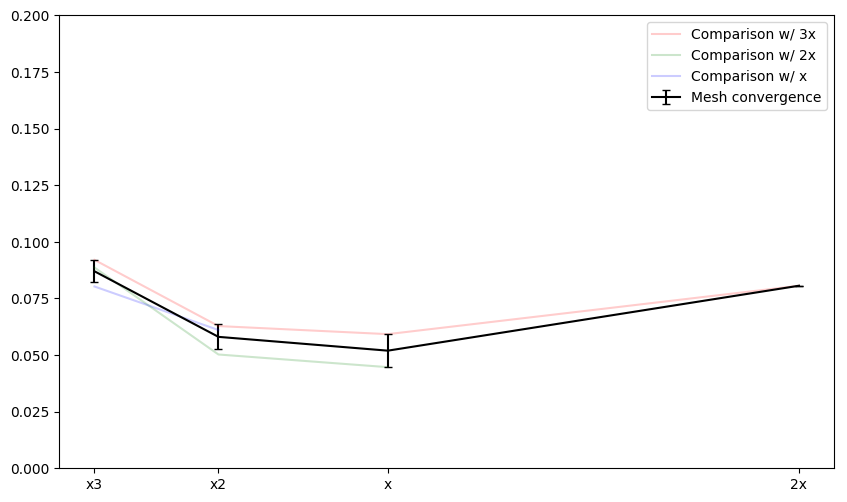

In [11]:
f, ax1 = plt.subplots(1, figsize=(10,6), dpi=100)
# plotting the mean error of each field substraction compared with respect different meshes
ax1.plot(nodes[:-1], mean[[3,6,8,9]], color = 'r', label='Comparison w/ 3x', alpha = 0.2)
ax1.plot(nodes[:-2], mean[[2,5,7]], color = 'g', label='Comparison w/ 2x', alpha = 0.2)
ax1.plot(nodes[:-3], mean[[1,4]], color = 'b', label='Comparison w/ x', alpha = 0.2)
# trend for the data
ax1.errorbar(nodes[:-1], [np.mean(mean[[1,2,3]]), np.mean(mean[[4,5,6]]), np.mean(mean[[7,8]]), np.mean(mean[9])], 
             [np.std(mean[[1,2,3]]), np.std(mean[[4,5,6]]), np.std(mean[[7,8]]), np.std(mean[9])], color = 'black', capsize = 3, label = 'Mesh convergence')
# ticks and label customization
ax1.set_xticks(nodes[:-1])
ax1.set_xticklabels(dataSetsString[:-1])
ax1.set_ylim([0,0.2])
ax1.legend()

Regarding the results obtained above, it can be seen that the most accurate mesh is the one labeled as <tt> x </tt>, and it will be used for further studies on the topics of flow control and vortex shedding supression.

However the results are not accurate and a better way of comparing the data must be used in order to draw some conclusions with respect to mesh size. The main claim is that, once the **mesh size is big enough, vortex sheding will occur**. 